In [702]:
import torch
import torch.nn.functional as F
import math
from torch.autograd import Variable

In [703]:
def grad_scale(x, scale):
    y = x
    y_grad = x * scale
    return y.detach() - y_grad.detach() + y_grad

def round_pass(x):
    y = x.round()
    y_grad = x
    return y.detach() - y_grad.detach() + y_grad

In [704]:
nbits = 4
Qn = -2 ** (nbits - 1)
Qp = 2 ** (nbits - 1) - 1
g = 1/2
print(g)

0.5


### Method1: According to the LSQ+ paper

In [705]:
ws = []
wqs = []
alpha_grads = []
offset_grads = []
for i in range(-1000, 1000):
    weight = Variable(torch.Tensor([i * 0.01]), requires_grad=True)
    weigth_offset = Variable(torch.tensor(0.2), requires_grad=True)
    alpha = torch.ones(1, requires_grad=True)
    ws.append(weight.data[0])
    alpha2 = grad_scale(alpha, g)
    w_q = round_pass((weight - weigth_offset)/alpha2).clamp(Qn, Qp) * alpha2 + weigth_offset
    w_q_back = round_pass(((weight - weigth_offset)/alpha2).clamp(Qn, Qp)) * alpha2 + weigth_offset
    assert(w_q == w_q_back)
    if i == 720:
        print(g, alpha2, weight)
    wqs.append(w_q.data[0])
    w_q.backward()
    alpha_grads.append(alpha.grad)
    offset_grads.append(weigth_offset.grad)
print(ws[0:700:70])
print(wqs[0:700:70])
print(alpha_grads[0:700:70])
print(offset_grads[0:700:70])

0.5 tensor([1.], grad_fn=<AddBackward0>) tensor([7.2000], requires_grad=True)
[tensor(-10.), tensor(-9.3000), tensor(-8.6000), tensor(-7.9000), tensor(-7.2000), tensor(-6.5000), tensor(-5.8000), tensor(-5.1000), tensor(-4.4000), tensor(-3.7000)]
[tensor(-7.8000), tensor(-7.8000), tensor(-7.8000), tensor(-7.8000), tensor(-6.8000), tensor(-6.8000), tensor(-5.8000), tensor(-4.8000), tensor(-4.8000), tensor(-3.8000)]
[tensor([-4.]), tensor([-4.]), tensor([-4.]), tensor([0.0500]), tensor([0.2000]), tensor([-0.1500]), tensor([0.]), tensor([0.1500]), tensor([-0.2000]), tensor([-0.0500])]
[tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.)]


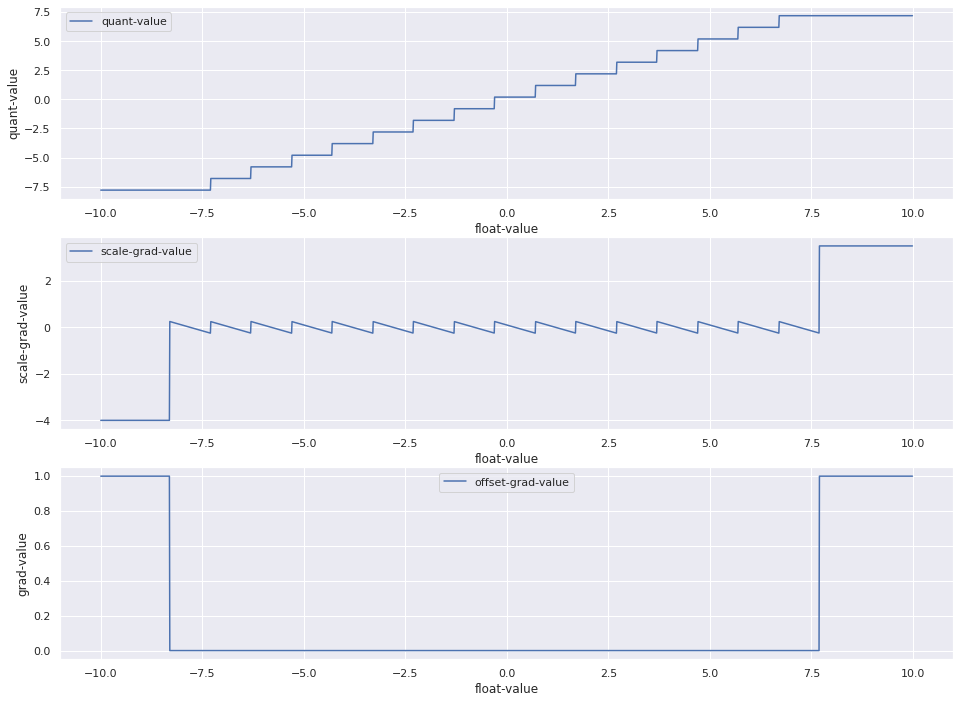

In [706]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import *
import numpy as np

with sns.axes_style("darkgrid"):
    sns.set(rc={"figure.figsize": (16, 12)})
    df1 = pd.DataFrame( np.array(wqs), np.array(ws), columns = ["quant-value"])
    #print(df1)
    subplot(3,1,1)
    ax = sns.lineplot(data = df1)
    ax.set_ylabel("quant-value")
    ax.set_xlabel("float-value")
    
    subplot(3,1,2)
    df2 = pd.DataFrame( np.array(alpha_grads), np.array(ws), columns = ["scale-grad-value"])
    ax = sns.lineplot(data = df2)
    ax.set_ylabel("scale-grad-value")
    ax.set_xlabel("float-value")
    
    subplot(3,1,3)
    df3 = pd.DataFrame( np.array(offset_grads), np.array(ws), columns = ["offset-grad-value"])
    ax = sns.lineplot(data = df3)
    ax.set_ylabel("grad-value")
    ax.set_xlabel("float-value")
    
    plt.show()

### Method2: Customer Backward

In [707]:
class LSQPlus(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, scale, beta, lower_bound, upper_bound):
        r"""
        LSQPlus: y = Round[clamp((x - beta)/s, n, p)] * s + beta
        Args:
            x: input tensor
            scale: QAT scale
            beta: QAT offset
        return:
            x_quant: quantization tensor of x
        """
        x_hat = ((x - beta) / scale).round()
        ctx.save_for_backward(x, x_hat, scale, beta)
        ctx.constant = [lower_bound, upper_bound]
        x_hat = x_hat.clamp(lower_bound, upper_bound)
        x_quant = x_hat * scale + beta
        return x_quant
    
    @staticmethod
    def backward(ctx, grad_output):
        r"""
        Backward:
            x_gradient: x[x > p or x < n] = 0 else 1
            scale_gradient: -(x - beta)/s + round[(x - beta)/s] else n or p
            beta_gradient: 0 or 1
        """
        x, x_hat, scale, beta = ctx.saved_variables
        lower_bound, upper_bound = ctx.constant

        idx_smaller = (((x - beta)/scale).round() < lower_bound)
        idx_bigger = (((x - beta)/scale).round() > upper_bound)
        #g_scale = 1.0 / math.sqrt(x.numel() * upper_bound) 
        #g_offset =  min(1.0, 1.0 / math.sqrt(idx_smaller.sum() + idx_bigger.sum() + 1e-6))
        g_scale = 1/2
        g_offset = 1.0

        r"""1. input gradient"""
        x_grad = torch.ones_like(grad_output)
        x_grad[idx_smaller] = 0
        x_grad[idx_bigger] = 0
        x_grad *= grad_output

        r"""2. scale gradient"""
        scale_grad = -(x - beta)/scale + x_hat
        scale_grad[idx_smaller] = float(lower_bound)
        scale_grad[idx_bigger] = float(upper_bound)
        scale_grad = (scale_grad * grad_output).sum().unsqueeze(dim=0) * g_scale

        r"""3. offset gradient"""
        beta_grad = torch.zeros_like(x)
        beta_grad[idx_smaller] = 1
        beta_grad[idx_bigger] = 1
        beta_grad = (beta_grad * grad_output).sum().unsqueeze(dim=0) * g_offset
        return x_grad, scale_grad, beta_grad, None, None

In [708]:
ws = []
wqs2 = []
alpha_grads2 = []
offset_grads2 = []
for i in range(-1000, 1000):
    weight = Variable(torch.Tensor([i * 0.01]), requires_grad=True)
    weigth_offset = Variable(torch.tensor(0.2), requires_grad=True)
    ws.append(weight.data[0])
    alpha = torch.ones(1, requires_grad=True)
    w_q = LSQPlus.apply(weight, alpha, weigth_offset, Qn, Qp)
    wqs2.append(w_q.data[0])
    w_q.backward()
    alpha_grads2.append(alpha.grad)
    offset_grads2.append(weigth_offset.grad)

print(ws[0:700:70])
print(wqs2[0:700:70])
print(alpha_grads2[0:700:70])
print(offset_grads2[0:700:70])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'


[tensor(-10.), tensor(-9.3000), tensor(-8.6000), tensor(-7.9000), tensor(-7.2000), tensor(-6.5000), tensor(-5.8000), tensor(-5.1000), tensor(-4.4000), tensor(-3.7000)]
[tensor(-7.8000), tensor(-7.8000), tensor(-7.8000), tensor(-7.8000), tensor(-6.8000), tensor(-6.8000), tensor(-5.8000), tensor(-4.8000), tensor(-4.8000), tensor(-3.8000)]
[tensor([-4.]), tensor([-4.]), tensor([-4.]), tensor([0.0500]), tensor([0.2000]), tensor([-0.1500]), tensor([0.]), tensor([0.1500]), tensor([-0.2000]), tensor([-0.0500])]
[tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.)]


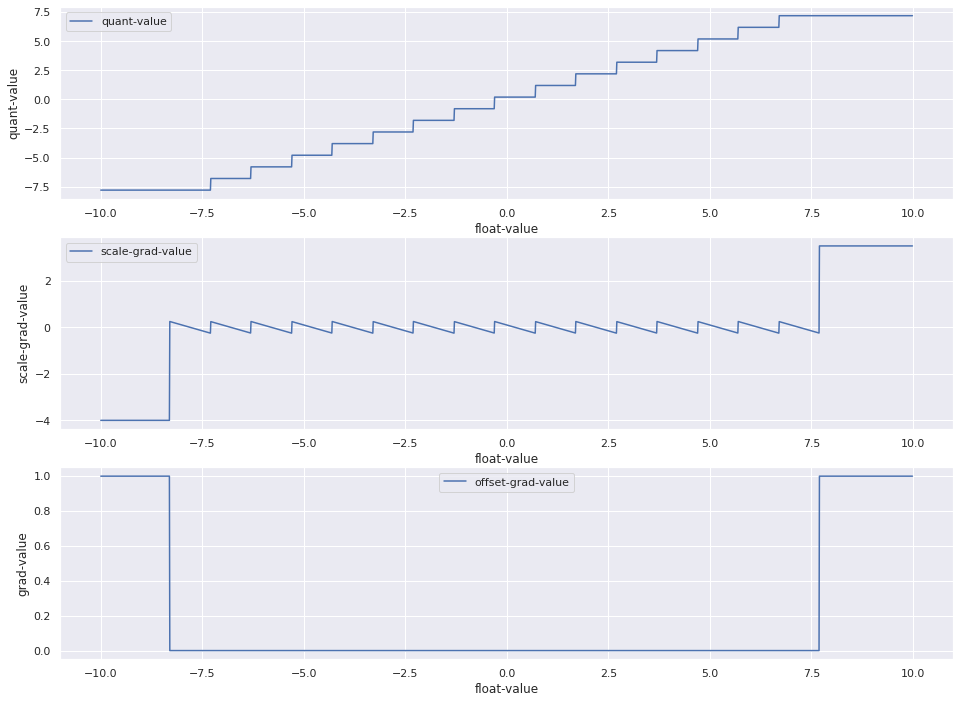

In [709]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import *
import numpy as np

with sns.axes_style("darkgrid"):
    sns.set(rc={"figure.figsize": (16, 12)})
    df1 = pd.DataFrame( np.array(wqs2), np.array(ws), columns = ["quant-value"])
    #print(df1)
    subplot(3,1,1)
    ax = sns.lineplot(data = df1)
    ax.set_ylabel("quant-value")
    ax.set_xlabel("float-value")
    
    subplot(3,1,2)
    df2 = pd.DataFrame( np.array(alpha_grads2), np.array(ws), columns = ["scale-grad-value"])
    ax = sns.lineplot(data = df2)
    ax.set_ylabel("scale-grad-value")
    ax.set_xlabel("float-value")
    
    subplot(3,1,3)
    df3 = pd.DataFrame( np.array(offset_grads2), np.array(ws), columns = ["offset-grad-value"])
    ax = sns.lineplot(data = df3)
    ax.set_ylabel("grad-value")
    ax.set_xlabel("float-value")
    
    plt.show()

In [710]:
print(wqs == wqs2)
print(alpha_grads == alpha_grads2)
print(offset_grads == offset_grads2)

print(np.array(alpha_grads[719:775]))
print(np.array(alpha_grads2[719:750]))
print(alpha_grads == alpha_grads2)

for idx, val in enumerate(alpha_grads):
    if alpha_grads[idx] != alpha_grads2[idx]:
        print( idx, " : ", ws[idx], wqs[idx],val , alpha_grads2[idx])
        break

True
True
True
[ 0.005       0.         -0.005      -0.00999999 -0.01499999 -0.01999998
 -0.02499998 -0.02999997 -0.03499997 -0.03999996 -0.04499996 -0.04999995
 -0.05499995 -0.05999994 -0.06499994 -0.06999993 -0.07499993 -0.07999992
 -0.08499992 -0.09000003 -0.09500003 -0.10000002 -0.10500002 -0.11000001
 -0.11500001 -0.12       -0.125      -0.13       -0.13499999 -0.13999999
 -0.14499998 -0.14999998 -0.15499997 -0.15999997 -0.16499996 -0.16999996
 -0.17499995 -0.17999995 -0.18499994 -0.18999994 -0.19499993 -0.19999993
 -0.20499992 -0.20999992 -0.21500003 -0.22000003 -0.22500002 -0.23000002
 -0.23500001 -0.24000001 -0.245       0.25        0.245       0.24000001
  0.23500001  0.23000002]
[ 0.005       0.         -0.005      -0.00999999 -0.01499999 -0.01999998
 -0.02499998 -0.02999997 -0.03499997 -0.03999996 -0.04499996 -0.04999995
 -0.05499995 -0.05999994 -0.06499994 -0.06999993 -0.07499993 -0.07999992
 -0.08499992 -0.09000003 -0.09500003 -0.10000002 -0.10500002 -0.11000001
 -0.115000

### More Test

In [711]:
class LSQPlus(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, scale, beta, lower_bound, upper_bound):
        r"""
        LSQPlus: y = Round[clamp((x - beta)/s, n, p)] * s + beta
        Args:
            x: input tensor
            scale: QAT scale
            beta: QAT offset
        return:
            x_quant: quantization tensor of x
        """
        x_hat = ((x - beta) / scale).round()
        ctx.save_for_backward(x, x_hat, scale, beta)
        ctx.constant = [lower_bound, upper_bound]
        x_hat = x_hat.clamp(lower_bound, upper_bound)
        x_quant = x_hat * scale + beta
        return x_quant
    
    @staticmethod
    def backward(ctx, grad_output):
        r"""
        Backward:
            x_gradient: x[x > p or x < n] = 0 else 1
            scale_gradient: -(x - beta)/s + round[(x - beta)/s] else n or p
            beta_gradient: 0 or 1
        """
        x, x_hat, scale, beta = ctx.saved_variables
        lower_bound, upper_bound = ctx.constant

        idx_smaller = (((x - beta)/scale).round() < lower_bound)
        idx_bigger = (((x - beta)/scale).round() > upper_bound)
        g_scale = 1.0 / math.sqrt(x.numel() * upper_bound) 
        #g_offset =  min(1.0, 1.0 / math.sqrt(idx_smaller.sum() + idx_bigger.sum() + 1e-6))
        g_offset = 1.0 / math.sqrt(x.numel() * upper_bound) 

        r"""1. input gradient"""
        x_grad = torch.ones_like(grad_output)
        x_grad[idx_smaller] = 0
        x_grad[idx_bigger] = 0
        x_grad *= grad_output

        r"""2. scale gradient"""
        scale_grad = -(x - beta)/scale + x_hat
        scale_grad[idx_smaller] = float(lower_bound)
        scale_grad[idx_bigger] = float(upper_bound)
        scale_grad = (scale_grad * grad_output).sum().unsqueeze(dim=0) * g_scale

        r"""3. offset gradient"""
        beta_grad = torch.zeros_like(x)
        beta_grad[idx_smaller] = 1
        beta_grad[idx_bigger] = 1
        beta_grad = (beta_grad * grad_output).sum().unsqueeze(dim=0) * g_offset
        return x_grad, scale_grad, beta_grad, None, None

In [712]:
import math
nbits = 4
Qn = -2 ** (nbits - 1)
Qp = 2 ** (nbits - 1) - 1

########### Method1 ###########
weight1 = torch.autograd.Variable(torch.from_numpy(np.arange(-2000, 2000)) * 0.001, requires_grad = True)
weight_alpha1 = torch.tensor(0.2, requires_grad=True)
weight_offset1 = torch.tensor(0.2, requires_grad=True)

g = 1.0 / math.sqrt(weight1.numel() * Qp)
weight_alpha1_ = grad_scale(weight_alpha1, g)
weight_offset1_ = grad_scale(weight_offset1, g)
w_q1 = round_pass((weight1 - weight_offset1_) / weight_alpha1_).clamp(Qn, Qp) * weight_alpha1_ + weight_offset1_
w_q1.sum().backward()

print(weight_alpha1.grad)
print(weight_offset1.grad)

########### Method2 ###########
weight2 = torch.autograd.Variable(torch.from_numpy(np.arange(-2000, 2000)) *0.001, requires_grad = True)
weight_alpha2 = torch.tensor(0.2, requires_grad=True)
weight_offset2 = torch.tensor(0.2, requires_grad=True)

g = 1.0 / math.sqrt(weight2.numel() * Qp)
#weight_alpha2_ = grad_scale(weight_alpha2, g)
#weight_offset2_ = grad_scale(weight_offset2, g)
#w_q2 = round_pass((weight2 - weight_offset2_) / weight_alpha2_).clamp(Qn, Qp) * weight_alpha2_ + weight_offset2_
w_q2 = LSQPlus.apply(weight2, weight_alpha2, weight_offset2, Qn, Qp)
w_q2.sum().backward()

print(weight_alpha2.grad)
print(weight_offset2.grad)
print(torch.equal(weight1.grad, weight2.grad))
print(torch.equal(w_q1, w_q2))
print(torch.equal(weight_alpha1,weight_alpha2))
print(torch.equal(weight_alpha1.grad, weight_alpha2.grad))
print(torch.equal(weight_offset1, weight_offset2))
print(torch.equal(weight_offset1.grad, weight_offset2.grad))

tensor(-11.3935)
tensor(4.7869)
tensor(-11.3935)
tensor(4.7869)
True
True
True
False
True
True


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'


### TEST

In [713]:
import torch
import torch.nn as nn
import random
import numpy as np
import torch.nn.functional as F
from torch.nn.parameter import Parameter

seed = 6
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [721]:
class Clamp(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, min = 0, max = 1):
        ctx.save_for_backward(x)
        ctx.constant = [min, max]
        return x.clamp(min, max)
    @staticmethod
    def backward(ctx, g):
        x, = ctx.saved_tensors
        min, max = ctx.constant 
        grad_input = g.clone()
        grad_input[x < min] = 0
        grad_input[x > max] = 0
        return grad_input, None, None

class Round(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.input = input
        return torch.round(input)

    @staticmethod
    def backward(ctx, grad_output):
        grad_input = grad_output.clone()
        return grad_input


In [738]:
class LSQPlus(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, scale, beta, lower_bound, upper_bound):
        r"""
        LSQPlus: y = Round[clamp((x - beta)/s, n, p)] * s + beta
        Args:
            x: input tensor
            scale: QAT scale
            beta: QAT offset
        return:
            x_quant: quantization tensor of x
        """
        x_hat = ((x - beta) / scale).round()
        ctx.save_for_backward(x, x_hat, scale, beta)
        ctx.constant = [lower_bound, upper_bound]
        x_hat = x_hat.clamp(lower_bound, upper_bound)
        x_quant = x_hat * scale + beta
        return x_quant
    
    @staticmethod
    def backward(ctx, grad_output):
        r"""
        Backward:
            x_gradient: x[x > p or x < n] = 0 else 1
            scale_gradient: -(x - beta)/s + round[(x - beta)/s] else n or p
            beta_gradient: 0 or 1
        """
        print(grad_output[0, 0, 1, :].detach().numpy())
        x, x_hat, scale, beta = ctx.saved_variables
        lower_bound, upper_bound = ctx.constant

        idx_smaller = (((x - beta)/scale).round() < lower_bound)
        idx_bigger = (((x - beta)/scale).round() > upper_bound)
        g_scale = 1.0 / math.sqrt(x.numel() * upper_bound) 
        #g_offset =  min(1.0, 1.0 / math.sqrt(idx_smaller.sum() + idx_bigger.sum() + 1e-6))
        g_offset = 1.0 / math.sqrt(x.numel() * upper_bound) 

        r"""1. input gradient"""
        x_grad = torch.ones_like(grad_output)
        x_grad[idx_smaller] = 0
        x_grad[idx_bigger] = 0
        x_grad *= grad_output

        r"""2. scale gradient"""
        scale_grad = -(x - beta)/scale + x_hat
        scale_grad[idx_smaller] = float(lower_bound)
        scale_grad[idx_bigger] = float(upper_bound)
        scale_grad = (scale_grad * grad_output).sum().unsqueeze(dim=0) * g_scale

        r"""3. offset gradient"""
        beta_grad = torch.zeros_like(x)
        beta_grad[idx_smaller] = 1
        beta_grad[idx_bigger] = 1
        beta_grad = (beta_grad * grad_output).sum().unsqueeze(dim=0) * g_offset
        return x_grad, scale_grad, beta_grad, None, None

In [739]:
nbits_w = 4
Qn = -(2 ** (nbits_w - 1))
Qp = 2 ** (nbits_w - 1) - 1

torch.manual_seed(seed)
x1 = torch.randn((2,3, 5, 5))
x1.requires_grad_()
torch.manual_seed(seed)
y1 = torch.randn((2, 10))

torch.manual_seed(seed)
weight1 = Parameter(torch.rand(20, 3,  3, 3))

### weight quant
weigth_aplha1_ = Parameter(torch.max( torch.abs(weight1.mean() - 3 * weight1.std()), 
                    torch.abs(weight1.mean() + 3 * weight1.std())) / ((Qp - Qn)/2))
weight_offset1_ = Parameter(weight1.mean())

g = 1.0 / math.sqrt(weight1.numel() * Qp) 
weight_alpha1 = grad_scale(weigth_aplha1_, g)
weight_offset1 = grad_scale(weight_offset1_, g)
#w_q1 = round_pass(((weight1 - weight_offset1) / weight_alpha1).clamp(Qn, Qp)) * weight_alpha1 + weight_offset1
w_q1 = Round.apply(Clamp.apply((weight1 - weight_offset1) / weight_alpha1, Qn, Qp)) * weight_alpha1 + weight_offset1
w_q1.retain_grad()

### act quant
act_alpha1_  = Parameter(2 * x1.abs().mean() / math.sqrt(Qp))
act_offset1_ = Parameter(x1.min() * 0.9 - Qn * act_alpha1_)

act_alpha1 = grad_scale(act_alpha1_, g)
act_offset1 = grad_scale(act_offset1_, g)
#x_q1 = round_pass(((x1 - act_offset1) / act_alpha1).clamp(Qn, Qp)) * act_alpha1 + act_offset1
x_q1 = Round.apply(Clamp.apply((x1 - act_offset1) / act_alpha1, Qn, Qp)) * act_alpha1 + act_offset1
x_q1.retain_grad()

res1 = F.conv2d(x_q1, w_q1, None, 1, 1, 1)
sum_res1 = res1.sum()
sum_res1.backward()

In [740]:
nbits_w = 4
Qn = -(2 ** (nbits_w - 1))
Qp = 2 ** (nbits_w - 1) - 1

torch.manual_seed(seed)
x2 = torch.randn((2,3, 5, 5))
x2.requires_grad_()
torch.manual_seed(seed)
y2 = torch.randn((2, 10))

torch.manual_seed(seed)
weight2 = Parameter(torch.rand(20, 3,  3, 3))

### weight quant
weigth_aplha2_ = Parameter(torch.max( torch.abs(weight2.mean() - 3 * weight2.std()), 
                    torch.abs(weight2.mean() + 3 * weight2.std())) / ((Qp - Qn)/2))
weight_offset2_ = Parameter(weight2.mean())

w_q2 = LSQPlus.apply(weight2, weigth_aplha2_, weight_offset2_, Qn, Qp)
w_q2.retain_grad()

### act quant
act_alpha2_  = Parameter(2 * x2.abs().mean() / math.sqrt(Qp))
act_offset2_ = Parameter(x2.min() * 0.9 - Qn * act_alpha2_)
x_q2 = LSQPlus.apply(x2, act_alpha2_, act_offset2_, Qn, Qp)
x_q2.retain_grad()

res2 = F.conv2d(x_q2, w_q2, None, 1, 1, 1)
sum_res2 = res2.sum()
sum_res2.backward()

[66.614296 97.47418  97.47418  97.47418  63.17001 ]
[-9.031926 -8.571491 -6.615556]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'


In [741]:
## 1. Inference
print("\nforward:")
print(torch.equal(x1, x2))
print(torch.equal(weight1, weight2))

print(torch.equal(w_q1, w_q2))
print(torch.equal(x_q1, x_q2))

print(torch.equal(weigth_aplha1_, weigth_aplha2_))
print(torch.equal(weight_offset1_, weight_offset2_))

## 2. backward
print("\nBackward:")
print(torch.equal(x1.grad, x2.grad))
print(torch.equal(weight1.grad, weight2.grad))

print(torch.equal(w_q1.grad, w_q2.grad))
print(torch.equal(x_q1.grad, x_q2.grad))

print(torch.equal(weigth_aplha1_.grad, weigth_aplha2_.grad))
print(torch.equal(weight_offset1_.grad, weight_offset2_.grad))


forward:
True
True
True
True
True
True

Backward:
False
False
True
True
False
False


In [742]:
weight_diff_idx = x1.grad ==x2.grad
print("weight1 grad:\n", x1.grad[weight_diff_idx == False].detach().numpy())
print("weight2_grad:\n", x2.grad[weight_diff_idx == False].detach().numpy())

weight1 grad:
 [63.170006 63.170006 63.170006 60.450848 60.450848 60.450848 59.544453
 59.544453 59.544453 63.170006 63.170006 63.170006  0.       60.450848
 60.450848 60.450848 59.544453 59.544453 59.544453]
weight2_grad:
 [63.17001  63.17001  63.17001  60.450844 60.450844 60.450844 59.54445
 59.54445  59.54445  63.17001  63.17001  63.17001  67.3394   60.450844
 60.450844 60.450844 59.54445  59.54445  59.54445 ]


In [727]:
print(x1.grad[0,0,1,4].detach().numpy())
print(x2.grad[0,0,1,4].detach().numpy())
print(x_q1.grad[0,0,1,4].detach().numpy())
print(x_q2.grad[0,0,1,4].detach().numpy())

63.170006
63.17001
63.17001
63.17001


In [693]:
weight_diff_idx

tensor([[[[ True,  True,  True,  True,  True],
          [ True,  True,  True,  True, False],
          [ True,  True,  True,  True, False],
          [ True,  True,  True,  True, False],
          [ True,  True,  True,  True,  True]],

         [[ True, False, False, False,  True],
          [ True,  True,  True,  True,  True],
          [ True,  True,  True,  True,  True],
          [ True,  True,  True,  True,  True],
          [ True,  True,  True,  True,  True]],

         [[ True,  True,  True,  True,  True],
          [ True,  True,  True,  True, False],
          [ True,  True,  True,  True, False],
          [ True,  True,  True,  True, False],
          [ True,  True,  True,  True,  True]]],


        [[[ True,  True,  True,  True,  True],
          [ True,  True,  True,  True, False],
          [ True,  True,  True,  True, False],
          [ True,  True,  True,  True, False],
          [ True, False,  True,  True,  True]],

         [[ True, False, False, False,  True],
   